# Temp Analysis

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [168]:
sns.set_theme()

In [169]:
TEMP_GLOBAL_FILE = 'data/processed/temperature/temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'data/processed/temperature/temp-land-region.csv'
TEMP_COUNTRY_FILE = 'data/processed/temperature/temp-land-country.csv'
DIS_ALL_FILE = 'data/processed/disaster/disaster-all.csv'

In [170]:
# Todo: replace when merging
temp_global = pd.read_csv(TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_COUNTRY_FILE)
dis_all = pd.read_csv(DIS_ALL_FILE)

## Add smoothing

We apply lowess smoothing to the temperature anomaly data and add it to our datasets.

In [171]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [172]:
temp_global = lowess_grouped(temp_global, "year", "temperature_anomaly", None, frac=0.05)
temp_region = lowess_grouped(temp_region, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country = lowess_grouped(temp_country, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global temperature trend

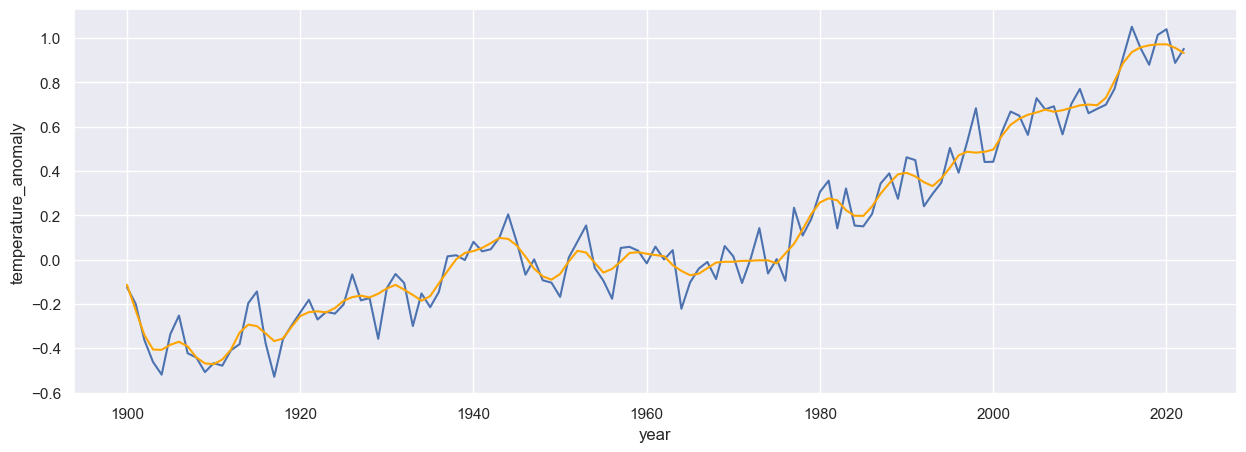

In [173]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global, color="orange");

In the plot we can observe what seems to be a positive trend for the temperature anomalies, especially in the last 20 years all temperature anomalies have a positive value.

We fit a linear regression to the smoothed temperature anomaly data, to observe what seems like a positive trend further.

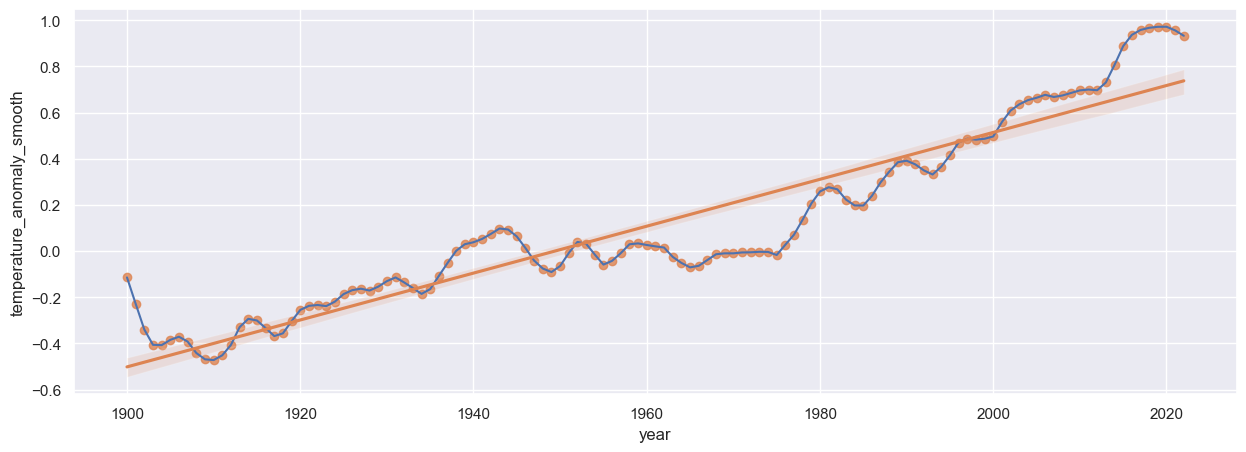

In [174]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global)
sns.regplot(x="year", y="temperature_anomaly_smooth", data=temp_global);

When fitting a linear regression to the temperature anomaly data, the positive trend for the past 120 years becomes clearly visible.

## Regional temperature trend

We plot the smoothed temperature anomaly data for the regions Africa, Oceania, Americas, Asia and Europe.

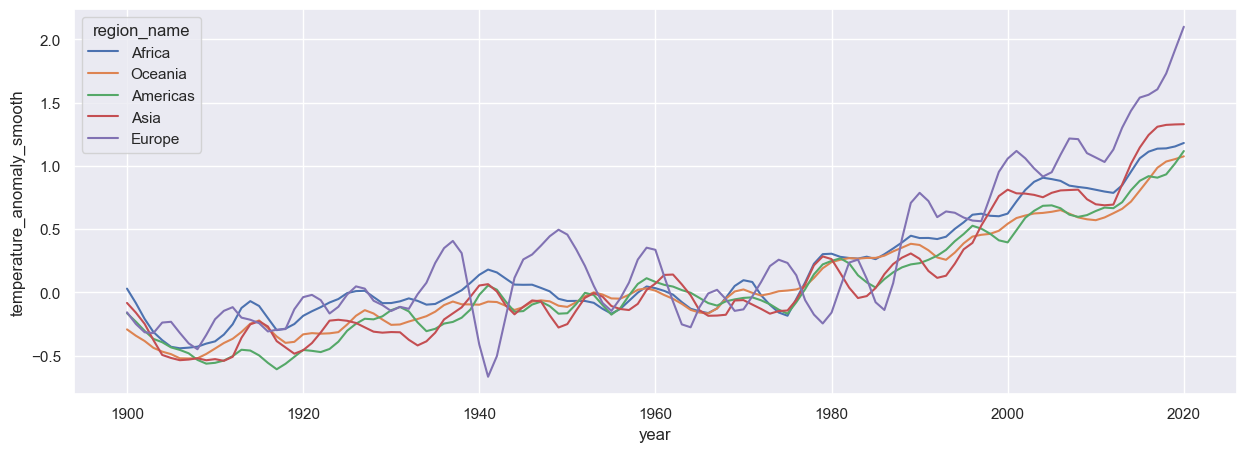

In [175]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", hue="region_name", data=temp_region, ax=ax);

Again, we can see what seems to be a positive trend, with an especially stronger increase in the past 20 years. Europe seems to have the most extreme temperature anomalies and the strongest increase in the past 20 years.

## Did some countries have extremer temperature anomalies than others?

We try to detect which countries have the most extreme temperature anomalies in our dataset. We use three different approaches:

* Ranking countries based on their 2020 anomalies
* Ranking countries based on the slope parameter of a linear regression fitted to the anomalies
* Ranking countries by count of temperature anomaly outliers

### High anomaly in 2020

We sort countries based on their 2020 temperature anomaly values

In [176]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


In [177]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).tail()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27279,2020,SDN,0.528083,Sudan,0.595429
27136,2020,AFG,0.379750,Afghanistan,0.549394
27263,2020,PAK,0.531750,Pakistan,0.492607
27210,2020,IND,0.430750,India,0.485394
27260,2020,NPL,0.323667,Nepal,0.366796


In [178]:
def plot_countries_temp_anomalies(temp_countries):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i,country_code in enumerate(temp_countries):
        temp_selected_country = temp_country[temp_country["country_code"] == country_code]
        selected_country_name = temp_selected_country["country_name"].iloc[0]
        sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
    ax.legend();

### Linear regression

In [179]:
temp_regression_countries = []
for country_code in temp_country["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country[temp_country["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


### Outlier count

We plot a boxplot to see if outliers exist in the temperature anomly data.

C:\Users\Sebi\anaconda3\envs\dopp-a2_3-9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_anomaly'>

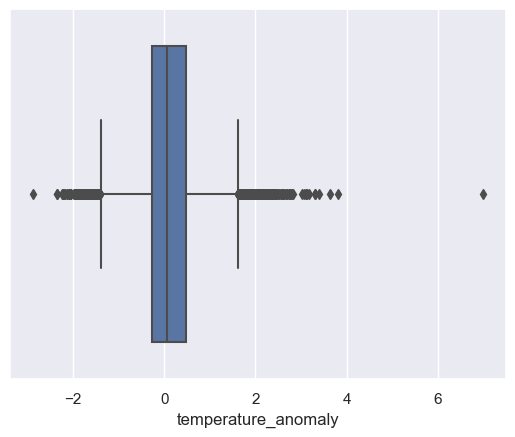

In [180]:
sns.boxplot(temp_country['temperature_anomaly'])

To determine at which value we can consider a temperature anomaly to be an outlier. We will calculate upper and lower bounds for temperature anomalies using the IQR and use these upper and lower bounds to determine outliers.

#### Calculate temperature anomaly IQR

In [181]:
temp_anomalies_np_arr = temp_country['temperature_anomaly'].to_numpy()
temp_anomalies_q3 = np.quantile(temp_anomalies_np_arr, 0.75)
temp_anomalies_q1 = np.quantile(temp_anomalies_np_arr, 0.25)
IQR = temp_anomalies_q3 - temp_anomalies_q1
IQR

0.7557916666666666

#### Calculate upper/lower bound for temp anomaly outliers using IQR

In [182]:
temp_anomaly_upper_bound = temp_anomalies_q3 + 1.5 * IQR
temp_anomaly_lower_bound = temp_anomalies_q1 - 1.5 * IQR
print(temp_anomaly_upper_bound)
print(temp_anomaly_lower_bound)

1.6220625
-1.4011041666666666


#### Detect extreme countries counting outliers based on IQR bounds

1. we filter for countries which include temperature anomaly outliers

2. we count the temperature anomaly outliers for each country and sort them by outlier count

In [183]:
temp_countries_anomaly_outlier = temp_country[(temp_country['temperature_anomaly'] >= temp_anomaly_upper_bound)
                                              | (temp_country['temperature_anomaly'] <= temp_anomaly_lower_bound)][['country_code', 'temperature_anomaly']]

temp_countries_anomaly_outlier = temp_countries_anomaly_outlier.groupby(['country_code']).count().sort_values(['temperature_anomaly'], ascending=False)
temp_countries_anomaly_outlier

,temperature_anomaly
country_code,
SJM,32
FIN,29
EST,25
LVA,22
LTU,22
...,...
MLI,1
SDN,1
MLT,1


### Plotting extreme countries

With our three different approaches we found, that the following five countries are the most extreme for each approach:
* LVA, EST, RUS, LTU, BLR
* MNG, ATA, SJM, KGZ, KAZ
* SJM, FIN, EST, LVA, LTU

Plotting together all the extreme countries would make the plot hard to read, therefore we decide to plot just a few extreme countries. We decide to use the countries SJM and LTU as examples for the extreme countries.

To have a comparison we will add the countries USA and MEX as not extreme examples to the plot.

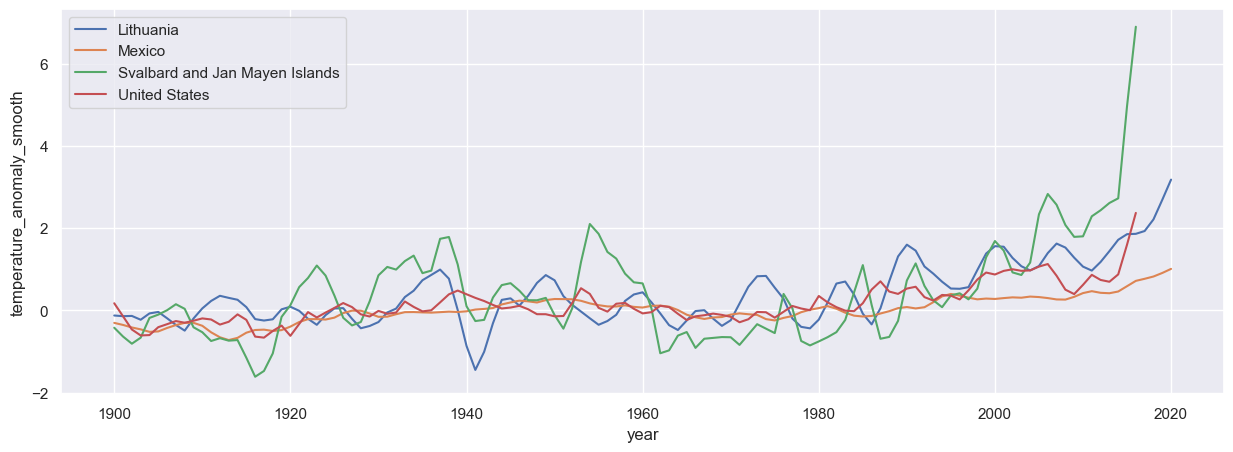

In [184]:
temp_plot_extreme_countries = ["SJM", "LTU", "USA", "MEX"]

temp_plot_extreme_countries = np.unique(temp_plot_extreme_countries)
plot_countries_temp_anomalies(temp_plot_extreme_countries)

As expected, the temperature anomalies of SJM and LTU are more extreme throughout the observed time period compared to the ones of the countries USA and MEX. However the temperature anomalies of all countries rise after 2000

### Observation of a correlation between natural disasters and climate change

To observe if a correlation between natural disasters and climate change exist.

For calculating the correlation we use the temperature anomalies and the total number of disaster deaths on a yearly basis.

First we filter the disaster data to just include disasters of the types Drought, Earthquake, Storm, Flood, Wildfire and Extreme temperature.

In [185]:
keep_types = ['Drought', 'Earthquake', 'Storm', 'Flood', 'Wildfire', 'Extreme temperature ']
dis_interesting_types = dis_all.loc[dis_all['type'].isin(keep_types),:]

#### Correlation of total natural disaster deaths with temperature anomalies

We are going to combine disaster and global temperature data to create a DataFrame for further correlation calculation.

First we group the disaster data by year and type and sum up the number of deaths for each year and type.

Then we transform our dataframe to a wide format, to get one row for each year and a column for the deaths of each disaster type.

In [186]:
dis_global_yearly_deaths = dis_interesting_types[['year', 'type', 'deaths']].groupby(['year', 'type']).agg('sum').reset_index()
dis_global_yearly_deaths_wide = pd.pivot(dis_global_yearly_deaths, index='year', columns='type', values='deaths')
dis_global_yearly_deaths_wide.head(3)

type,Drought,Earthquake,Extreme temperature,Flood,Storm,Wildfire
year,,,,,,
1900,1261000.0,140.0,NaN,300.0,6000.0,NaN
1901,NaN,18.0,NaN,NaN,NaN,NaN
1902,NaN,9148.0,NaN,NaN,600.0,NaN


Because not every disaster type occurred each year, we are left with some NaN values, which we replace with 0.

We also change the column names to lowercase, add underscores instead of spaces and add _deaths as a suffix.

In [187]:
def reformatDisGlobalYearlyWide(dis_global_yearly_wide, suffix):
    dis_global_yearly_wide = dis_global_yearly_wide.fillna(0)
    dis_global_yearly_wide = dis_global_yearly_wide.astype('int32')
    dis_global_yearly_wide.columns = [c.replace(' ', '_').lower() for c in dis_global_yearly_wide.columns]
    dis_global_yearly_wide.rename(columns={'extreme_temperature_': 'extreme_temperature', 'mass_movement_(dry)': 'mass_movement_dry'}, inplace=True)
    dis_global_yearly_wide = dis_global_yearly_wide.add_suffix(suffix)
    dis_global_yearly_wide.reset_index(inplace=True)
    return dis_global_yearly_wide

In [188]:
dis_global_yearly_deaths_wide = reformatDisGlobalYearlyWide(dis_global_yearly_deaths_wide, "_deaths")

We add the smoothed temperature anomaly values to our dataframe

In [189]:
dis_global_yearly_deaths_wide['temperature_anomaly_smooth'] = temp_global['temperature_anomaly_smooth']

Plot correlations of temperature anomalies and total disaster deaths

In [190]:
def plotTempDisCorrelation(dis_temp_corr, temp_anomaly):
    corr = dis_temp_corr.drop('year', axis=1).corr(method='spearman')[[temp_anomaly]]
    corr.sort_values(by=temp_anomaly, inplace=True, ascending=False)
    corr = corr.T
    corr.drop(temp_anomaly, axis=1, inplace=True)
    cmap = sns.color_palette("rocket", as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,1))
    sns.heatmap(corr,annot=True,vmin=0, vmax=1,cmap=cmap, annot_kws={"size": 8},ax=ax)
    ax.set_title("Correlation Matrix", y=1);
    return

We plot the correlation of smoothed temperature anomalies with the total deaths of the disaster types Drought, Earthquake, Storm, Flood, Wildfire and Extreme temperature.

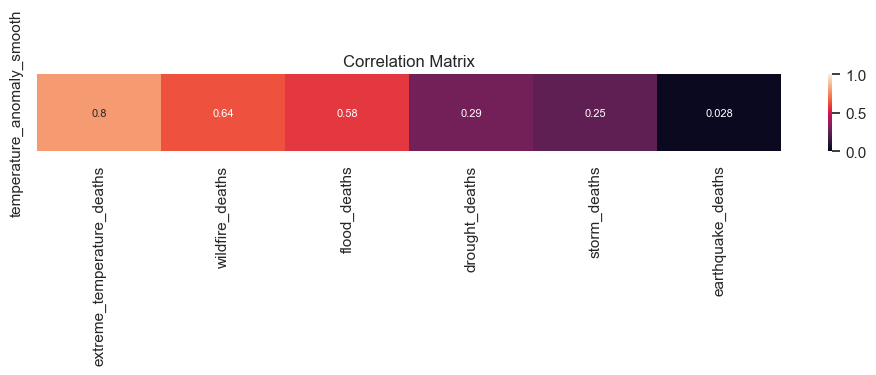

In [191]:
plotTempDisCorrelation(dis_global_yearly_deaths_wide, 'temperature_anomaly_smooth')

We find, that the correlation varies for different disaster types. As we would expect, disasters of the type Extreme temperatures have a strong correlation of 0.8 to temperature anomalies. The type Extreme temperatures does split in 3 subtypes, which we observe further in the next section.

Wildfire with a correlation of 0.64 and floods with 0.58 also are correlated with temperature anomalies.

Droughts and storm deaths are both weakly correlated, with coefficients smaller than 0.3.

Earthquakes are not correlated at all.

#### Correlation of subtypes of extreme temperature disasters with temperature anomalies

Now we will observe the correlation of subtypes of the disaster type Extreme temperature to temperature anomalies.

In [192]:
dis_type_extreme_temp = dis_all[dis_all['type'] == 'Extreme temperature ']
dis_type_extreme_temp = dis_type_extreme_temp[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
dis_type_extreme_temp_wide = pd.pivot(dis_type_extreme_temp, index='year', columns='subtype', values='deaths')
dis_type_extreme_temp_wide = reformatDisGlobalYearlyWide(dis_type_extreme_temp_wide, "_deaths")
dis_type_extreme_temp_wide = temp_global.merge(dis_type_extreme_temp_wide, how='left', on='year')
dis_type_extreme_temp_wide.fillna(0)
dis_type_extreme_temp_wide.drop('temperature_anomaly', axis=1, inplace=True)

Plot of the correlations of subtypes of disaster type Extreme temperature with smoothed temperature anomalies.

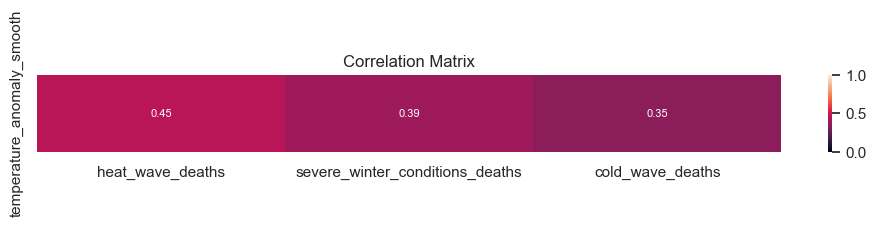

In [194]:
plotTempDisCorrelation(dis_type_extreme_temp_wide, 'temperature_anomaly_smooth')

We find, that the individual subtypes of Extreme temperature disasters are not as strongly correlated to temperature anomalies, with the highest correlation being 0.45 for the subtype heat wave deaths.

#### Correlation of disasters of type extreme temperature with temperature anomalies on a country level


In [195]:
def returnDisSubtypeTempCountry(country_code, subtype):
    dis_interesting_countries = dis_all[(dis_all['country_code']==country_code) & (dis_all['subtype']==subtype)]
    dis_country_yearly_heat_deaths = dis_interesting_countries[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
    dis_country_yearly_heat_deaths['deaths'] = dis_country_yearly_heat_deaths.deaths.astype('int32')
    dis_country_yearly_heat_deaths = temp_country[temp_country['country_code']==country_code].merge(dis_country_yearly_heat_deaths)
    dis_country_yearly_heat_deaths.fillna(0)
    return dis_country_yearly_heat_deaths[['year', 'temperature_anomaly_smooth', 'deaths']]

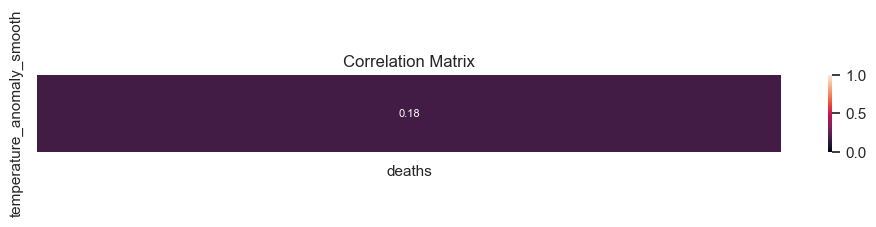

In [200]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('FRA', 'Heat wave'), 'temperature_anomaly_smooth')

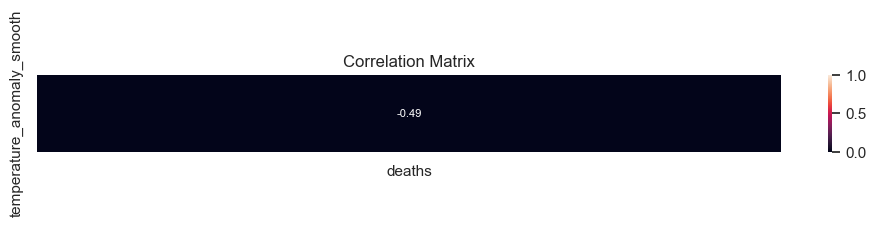

In [204]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('ESP', 'Heat wave'), 'temperature_anomaly_smooth')